In [5]:
import gurobipy as gu
import numpy as np
import matplotlib.pyplot as plt
from random import random, seed, randint
import imageio
path1 = "C:/Users/juan_/OneDrive - Universidad de los Andes/1. MIIND/Dani/"

In [6]:
# Parameters Generator Functions

''' Simulated historical data generator for quantities, prices and demand of products in each period.
    Returns:
        - M_kt: (dict) subset of suppliers that offer k \in K on t \in T
        - K_it: (dict) subset of products offered by i \in M on t \in T
        - q: (dict) quantity of k \in K offered by supplier i \in M on t \in T
        - p: (dict) price of k \in K offered by supplier i \in M on t \in T
        - dem: (dict) demand of k \in K on t \in T
    Parameters:
        - num_periods: (float) number of historical time periods to simulate, INCLUDING THE REALIZED DEMAND PERIODS
        - lambd: (float) lambda used for demand estimation
        - K: (iter) set of products
        - M: (iter) set of suppliers
        - Periods: (int) number of decision periods of the Rolling Horizon model'''
def gen_quantities_prices_demand(num_periods,lambd,K,M,Periods):
    
    TW = range(0-num_periods,Periods)
    
    M_kt= {}
    # In each time period, for each product
    for k in K:
        for t in TW:
            # Random number of suppliers that offer k in t
            sup = randint(1,len(M))
            M_kt[k,t] = list(M)
            # Random suppliers are removed from subset, regarding {sup}
            for ss in range(len(M)-sup):
                a = int(randint(0,len(M_kt[k,t])-1))
                del M_kt[k,t][a]
    
    # Products offered by each supplier on each time period, based on M_kt
    K_it = {(i,t):[k for k in K if i in M_kt[k,t]] for i in M for t in TW}
    
    # Random quantity of available product k, provided by supplier i on t
    q = {(i,k,t):randint(1,15) if i in M_kt[k,t] else 0 for i in M for k in K for t in TW}
    # Random price of available product k, provided by supplier i on t
    p = {(i,k,t):randint(1,500) if i in M_kt[k,t] else 1000 for i in M for k in K for t in TW}
    
    # Random demand of product k on t
    dem = {(k,t):randint(15,45) for k in K for t in TW}
    
    return M_kt, K_it, q, p, dem

''' Rolling horizon model parameters generation function
    Returns:
        - h: (dict) holding cost of k \in K on t \in T
        - O_k: (dict) maximum days that k \in K can be held in inventory
        - c: (dict) transportation cost between nodes i \in V and j \in V
        - I0: (dict) initial inventory level of k \in K, aged o \in O_k
    Parameters:
        - V: (iter) set of nodes in problem network (suppliers + warehouse)
        - T: (iter) set of decision periods in the rolling horizon model
        - K: (iter) set of products
        - M: (iter) set of suppliers
'''
def gen_params(V,T,K,M):
    # Random holding cost of product k on t
    h = {(k,t):randint(1,500) for k in K for t in T}
    # Fixed backorder cost of product k on t
    g = {(k,t):600 for k in K for t in T}
    
    # Maximum days that product k can be held in inventory before rotting
    O_k = {k:randint(1,len(T)) for k in K}
    
    # Suppliers locations in grid
    size_grid = 1000
    coor = {i:(randint(0, size_grid), randint(0, size_grid)) for i in V}
    # Transportation cost between nodes i and j, estimated using euclidean distance
    c = {(i,j):round(np.sqrt((coor[i][0]-coor[j][0])**2 + (coor[i][1]-coor[j][1])**2)) for i in V for j in V if i!=j}
    
    # Initial inventory level of product k, aged o at the beginning of the planning horizon
    I0 = {(k,o):0 for k in K for o in range(1,O_k[k]+1)}
    
    return h, g, O_k, c, I0

In [7]:
# Sample paths Generator

''' Sample value generator function.
    Returns a generated random number using acceptance-rejection method.
    Parameters:
    - hist: (list) historical dataset that is used as an empirical distribution for
            the random number generation'''
def sim(hist):
    Te = len(hist)
    sorted_data = sorted(hist)    
    
    prob, value = [], []
    for t in range(Te):
        prob.append((t+1)/Te)
        value.append(sorted_data[t])
    
    # Generates uniform random value for acceptance-rejection testing
    U = random()
    # Tests if the uniform random falls under the empirical distribution
    test = [i>U for i in prob]    
    # Takes the first accepted value
    sample = value[test.index(True)]
    
    return sample

''' Sample paths generator function.
    Returns:
        - M_kts: (dict) subset of suppliers that offer k \in K on t \in T in sample path s \in Sam
        - K_its: (dict) subset of products offered by i \in M on t \in T in sample path s \in Sam
        - q_s: (dict) quantity of k \in K offered by supplier i \in M on t \in T in sample path s \in Sam
        - p_s: (dict) price of k \in K offered by supplier i \in M on t \in T in sample path s \in Sam
        - dem_s: (dict) demand of k \in K on t \in T in sample path s \in Sam
        - Q_s: (float) feasible vehicle capacity to use in rolling horizon model in sample path s \in Sam
        - F_s: (iter) set of vehicles in sample path s \in Sam
    Parameters:
        - q: (dict) historical data of quantity of k \in K offered by supplier i \in M on t \in T
        - p: (dict) historical data of price of k \in K offered by supplier i \in M on t \in T
        - d: (dict) historical data of demand of k \in K on t \in T
        - M_kt: (dict) historical data of subset of suppliers that offer k \in K on t \in T
        - K_it: (dict) historical data of subset of products offered by i \in M on t \in T
        - today: (int) current time period on the Rolling Horizon model
        - K: (iter) set of products
        - M: (iter) set of suppliers
        - Sam: (int) number of sample paths to create
        - horizon: (int) number of periods to simulate in sample paths
        - today_is_known: (bool) whether today's parameters are known beforehand or not'''
def gen_sim_paths(q, p, d, M_kt, K_it, today, K, M, Sam, horizon, today_is_known):
    
    if today_is_known:
        TW = horizon[1:]
        Hist_T = range(-Historical,today+1)
    else:
        TW = horizon
        Hist_T = range(-Historical,today)
    
    M_kts,K_its = {},{}
    q_s,p_s,dem_s,Q_s,F_s = {},{},{},{},{}
    
    for s in Sam:
        # For each product, on each period chooses a random subset of suppliers that the product has had
        M_kts[s] = {(k,t):[M_kt[k,tt] for tt in Hist_T][randint(0,len(Hist_T)-1)] for k in K for t in TW}
        
        # Products offered by each supplier on each time period, based on M_kts
        K_its[s] = {(i,t):[k for k in K if i in M_kts[s][k,t]] for i in M for t in TW}
        
        # For each supplier and product, on each period chooses a quantity to offer using the sample value generator function
        q_s[s] = {(i,k,t):sim([q[i,k,tt] for tt in Hist_T if q[i,k,tt] > 0]) if i in M_kts[s][k,t] else 0 for i in M for k in K for t in TW}
        
        # For each supplier and product, on each period chooses a price using the sample value generator function
        p_s[s] = {(i,k,t):sim([p[i,k,tt] for tt in Hist_T if p[i,k,tt]<1000]) if i in M_kts[s][k,t] else 1000 for i in M for k in K for t in TW}
        
        # For each supplier and product, on each period chooses a demand using the sample value generator function
        dem_s[s] = {(k,t):sim([d[k,tt] for tt in Hist_T]) for k in K for t in TW}
        
        # If today's information is known beforehand, today's parameters are taken from the historical datasets
        if today_is_known:
            for k in K:
                M_kts[s][k,0] = M_kt[k,today]
                dem_s[s][k,0] = d[k,today]
                for i in M:
                    q_s[s][i,k,0] = q[i,k,today]
                    p_s[s][i,k,0] = p[i,k,today]
            for i in M:
                K_its[s][i,0] = K_it[i,today]
        
        # Vehicle capacity estimation
        Q_s[s] = 1.2*50
        
        # Set of vehicles, based on estimated required vehicles
        F_s[s] = range(int(sum(dem_s[s].values())/Q_s[s])+1)
        
    return M_kts, K_its, q_s, p_s, dem_s, Q_s, F_s

In [8]:
# Models functions

''' Inventory Management LP model
    Returns:
        - ii: (dict) inventory level of product k \in K aged o \in O_k at the end of the current decision period of the Rolling Horizon
        - r: (dict) quantity of product k \in K to be replenished on the current decision period of the Rolling Horizon
        - b: (dict) backorder quantity of product k \in K on the current decision period of the Rolling Horizon
        - I0: (dict) initial inventory level of product k \in K aged o \in O_k for the next decision period of the Rolling Horizon
    Parameters:
        - dec_p: (int) current decision period on the Rolling Horizon model
        - TW: (iter) set of decision periods for the lookahead model
        - d_s: (dict) demand of product k \in K on t \in TW in sample path s \in Sam
        - q_s: (dict) available quantity of product k \in K offered by supplier i \in M on t \in TW in sample path s \in Sam
        - M_kts: (dict) subset of suppliers that offer product k \in K on t \in TW in sample path s \in Sam
        - I0: (dict) initial inventory level of product k \in K aged o \in O_k on the current decision period
        - today_is_known: today_is_known: (bool) whether today's parameters are known beforehand or not
'''
def Inventory_LP(dec_p,TW,d_s,q_s,M_kts,I0,today_is_known):
    m = gu.Model('IM_perishable')
    
    ''' Decision Variables '''
    ###### Inventory variables
    # Quantity of product k \in K that is replenished on t \in TW, for sample path s \in Sam
    r = {(k,t,s):m.addVar(vtype=gu.GRB.CONTINUOUS, name=f"r_{k,t,s}") for k in K for t in TW for s in Sam}
    # Quantity of product k \in K aged o \in O_k shipped to final customer on t, for sample path s \in Sam
    y = {(k,t,o,s):m.addVar(vtype=gu.GRB.CONTINUOUS, name=f"y_{k,t,o,s}") for k in K for t in TW for o in range(1, O_k[k]+1) for s in Sam}
    # Backorder quantity of product k \in K on t \in TW, for sample path s \in Sam
    b = {(k,t,s):m.addVar(vtype=gu.GRB.CONTINUOUS,name=f"b_{k,t,s}") for k in K for t in TW for s in Sam}
    
    ''' State Variables '''
    # Inventory level of product k \in K aged o \in O_k on t \in TW, for sample path s \in Sam
    ii = {(k,t,o,s):m.addVar(vtype=gu.GRB.CONTINUOUS, name=f"i_{k,t,o,s}") for k in K for t in TW for o in range(1, O_k[k]+1) for s in Sam}
    
    ''' Constraints '''
    for s in Sam:
        #Inventory constraints
        ''' For each product k aged o, the inventory level on the first time period is
        the initial inventory level minus what was shipped of it in that same period'''
        for k in K:
            for o in range(1, O_k[k]+1):
                if o > 1:
                    m.addConstr(ii[k,0,o,s] == I0[k,o]-y[k,0,o,s])
        
        ''' For each product k on t, its inventory level aged 0 is what was replenished on t (r)
        minus what was shipped (y)'''
        for k in K:
            for t in TW:
                m.addConstr(ii[k,t,1,s] == r[k,t,s]-y[k,t,1,s])
                
        ''' For each product k, aged o, on t, its inventory level is the inventory level
        aged o-1 on the previous t, minus the amount of it that's shipped '''
        for k in K:
            for t in TW:
                for o in range(1, O_k[k]+1):
                    if t>0 and o>1:
                        m.addConstr(ii[k,t,o,s] == ii[k,t-1,o-1,s]-y[k,t,o,s])                
        
        ''' The amount of product k that is shipped to the final customer on t is equal to its demand'''
        for k in K:
            for t in TW:
                m.addConstr(gu.quicksum(y[k,t,o,s] for o in range(1, O_k[k]+1)) + b[k,t,s] == d_s[s][k,t])
        
        ''' Cannot buy more than the total farmers supply of product k on t '''
        for t in TW:
            for k in K:
                m.addConstr(r[k,t,s] <= sum(q_s[s][i,k,t] for i in M))
        
        ''' Non-Anticipativity Constraints'''
        for k in K:
            m.addConstr(r[k,0,s] == gu.quicksum(r[k,0,s1] for s1 in Sam)/len(Sam))
        
        if today_is_known:
            for k in K:
                m.addConstr(b[k,0,s] == gu.quicksum(b[k,0,s1] for s1 in Sam)/len(Sam))
            
            for k in K:
                for o in range(1, O_k[k]+1):
                    m.addConstr(y[k,0,o,s] == gu.quicksum(y[k,0,o,s1] for s1 in Sam)/len(Sam))
    
    ''' Backorders '''
    #m.addConstr(gu.quicksum(b[k,t,s] for k in K for t in TW for s in Sam)/len(Sam) <= 0.5*gu.quicksum(d_s[s][k,t] for k in K for t in TW for s in Sam)/len(Sam))
    
    ''' Costs - Objective Function '''
    holding = gu.quicksum(h[k,t+dec_p]*ii[k,t,o,s] for s in Sam for k in K for t in TW for o in range(1, O_k[k]+1))
    backl = gu.quicksum(g[k,t+dec_p]*b[k,t,s] for s in Sam for k in K for t in TW)
    m.setObjective((holding+backl)/len(Sam))
    
    # Runs model
    m.update()
    m.setParam("OutputFlag",0)
    m.optimize()
    
    
    ''' Saves results '''
    ii = {(k,t,o,s):ii[k,t,o,s].X for k in K for o in range(1,O_k[k]+1) for t in TW for s in Sam}
    r = {(k,t,s):round(r[k,t,s].X) for k in K for t in TW for s in Sam}
    b = {(k,t,s):b[k,t,s].X for k in K for t in TW for s in Sam}
    y = {(k,t,o,s):y[k,t,o,s].X for k in K for t in TW for o in range(1, O_k[k]+1) for s in Sam}
    
    return ii, r, b, y


''' Purchasing algorithm
    Returns:
        - z: (dict) quantity of product k \in K to buy from supplier i \in M
    Parameters:
        - r: (dict) (dict) quantity of product k \in K to be replenished on the current decision period of the Rolling Horizon
'''
def Purchasing(r,TW,p_s,q_s,purch_type):
    r = r.copy()
    z = {(i,k,t,s):0. for i in M for k in K for t in TW for s in Sam}
    for s in Sam:
        for t in TW:
            
            for k in K:
                
                # List of prices offered by suppliers for product k on the current decision period
                prices = [p_s[s][i,k,t] for i in M]
                # List of quantities offered by suppliers for product k on the current decision period
                quantities = [q_s[s][i,k,t] for i in M]
                # List of suppliers that offer product k on the current decision period
                MM = [i for i in M if q_s[s][i,k,t] > 0]
                
                # As long as it still hasn't bought everything it needs of product k
                while r[k,t,s] > 0:
                    if purch_type in ["g","greedy"]:
                        # Gets supplier that offers lowest price. Adds +1 bc suppliers start at 1 in M
                        i = prices.index(min(prices))+1
                        # Discards the selected supplier to account for possible ties in suppliers' prices
                        prices[i-1] = 1e3
                    elif purch_type in ["mq","max quantity"]:
                        # Gets supplier that offers max quantity. Adds +1 bc suppliers start at 1 in M
                        i = quantities.index(max(quantities))+1
                        # Discards the selected supplier to account for possible ties in suppliers' quantities
                        quantities[i-1] = 0
                    else:
                        # Gets random supplier
                        j = randint(0,len(MM)-1)
                        i = MM[j]
                        # Discards the selected supplier to account for possible ties in suppliers' prices
                        MM.pop(j)
                    # Decides quantity to buy from the selected supplier
                    z[i,k,t,s] = min(q_s[s][i,k,t],r[k,t,s])
                    # Updates quantity left to buy
                    r[k,t,s] -= z[i,k,t,s]
    
    return z


''' Routing tour generator
    Returns:
        - x: (dict) whether supplier j \in V is visited after supplier i \in V on t \in TW on sample path s \in S
    Parameters:
        - TW: (iter) set of decision periods of the lookahead model on the current decision period of the Rolling Horizon model
'''
def Routing_random(TW):
    ''' Tour creating function '''
    def create_tour():
        M1 = list(M).copy()
        tour = []
        while M1:
            i = randint(0,len(M1)-1)
            tour.append(M1[i])
            M1.pop(i)
        return tour
    
    ''' Routing decisions setting function '''
    def routing_decisions(x,tour):
        for i in range(len(tour)-1):
            x[tour[i],tour[i+1],t,s] = 1
        x[0,tour[0],t,s] = 1
        x[tour[-1],0,t,s] = 1
        
        return x
    
    x = {(i,j,t,s):0 for i in V for j in V for t in TW for s in Sam if i != j}
    for t in TW:
        if t == 0:
            tour = create_tour()
            for s in Sam:
                x = routing_decisions(x, tour)
        else:
            for s in Sam:
                tour = create_tour()
                x = routing_decisions(x,tour)
    
    return x

''' Routing tour generator
    Returns:
        - x: (dict) whether supplier j \in V is visited after supplier i \in V on t \in TW on sample path s \in S
    Parameters:
        - TW: (iter) set of decision periods of the lookahead model on the current decision period of the Rolling Horizon model
'''
def Routing(z,TW):
    z = z.copy()
    x = {}
    
    for k in K:
        
        for t in TW:
            for s in Sam:
                x[k,t,s] = [i for i in M if z[i,k,t,s] > 0]
    
    return x

''' Parameteres and Actions Realization function 
    Returns:
        - 
'''
def Realization(z,sttiaf,I0,tau,big_decisions):
    
    
    def Realize(z,sttiaf,I0,tau):
        z = z.copy()
        
        z_real = {(i,k):min(z[i,k,0,sttiaf],q[i,k,tau]) for i in M for k in K}
        ii_real = {}
        b_real = {}
        for k in K:
            
            left_to_comply = d[k,tau]
            for o in range(O_k[k],1,-1):
                y_real = min(I0[k,o], left_to_comply)
                ii_real[k,o] = I0[k,o] - y_real
                left_to_comply -= y_real
            
            y_real = min(sum(z_real[i,k] for i in M), left_to_comply)
            ii_real[k,1] = sum(z_real[i,k] for i in M) - y_real
            left_to_comply -= y_real
            
            b_real[k] = left_to_comply
        
        return z_real, ii_real, b_real
    
    z_real, ii_real, b_real = {}, {}, {}
    for alg in z:
        z_real[alg], ii_real[alg], b_real[alg] = Realize(z[alg],sttiaf,I0,tau)
    
    return z_real, ii_real, b_real

''' Tour creating function
    Returns:
        - tour
    Parameters:
        - K:
        - x
        - day
        - dec_day
        - t
        - s
'''
def create_tour(K,x,day,dec_day,t,s):
    x = x.copy()
    tour = [0]
    for k in K:
        tour += x[day][dec_day][k,t,s]
    tour = list(set(tour))
    tour.sort()
    tour.append(0)
    return tour

In [9]:
#%% Rolling Horizon function and Implementation

''' Rolling Horizon model function
    Returns:
        - res
    Parameters:
        - tau: current period on the RH model
'''
def Stochastic_Rolling_Horizon(today,sttiaf,big_decisions,I00):
    
    T = range(today+1)
    I0 = I00.copy()
    
    # Results dictionary
    res = {}
    for tau in T:
        
        # Time window adjustment
        adj_horizon = min(horizon_T,Periods-tau)
        TT = range(adj_horizon)
        
        ''' Sample paths generation '''
        M_kts, K_its, q_s, p_s, d_s, Q_s, F_s = gen_sim_paths(q, p, d, M_kt, K_it, tau,
                                                              K, M, Sam, TT, today_is_known)
        
        ''' Inventory Management Decisions '''
        ii,r,b,y = Inventory_LP(tau, TT, d_s, q_s, M_kts, I0, today_is_known)
        
        ''' Purchasing Decisions '''
        z = {alg:Purchasing(r, TT, p_s, q_s, alg) for alg in ["g","mq","r"]}
        
        ''' Routing Decisions '''
        x = {alg:Routing(z[alg], TT) for alg in ["g","mq","r"]}
        
        ''' Parameters and Actions Realization'''
        z_real, ii_real, b_real = Realization(z,sttiaf,I0,tau,big_decisions)
        
        ''' Initial inventory level updated for next decision period on the Rolling Horizon look-ahead'''
        if tau < today:
            I0 = {(k,o):ii_real[big_decisions[tau]][k,o-1] if o>1 else 0 for k in K for o in range(1,O_k[k]+1)}
        
        res[tau] = (ii, b, z, x, TT, d_s, p_s, q_s, z_real, ii_real, b_real)
    
    return res

In [10]:
# Results translation function

def results_translation(res, today, big_decisions):
    T = range(today+1)
    
    res = res.copy()
    ii = {tau:res[tau][0] for tau in T}
    b = {tau:res[tau][1] for tau in T}
    z = {tau:{key:res[tau][2][key] for key in res[tau][2]} for tau in T}
    x = {tau:{key:res[tau][3][key] for key in res[tau][3]} for tau in T}
    
    TW = {tau:res[tau][4] for tau in T}
    d_s = {tau:res[tau][5] for tau in T}
    p_s = {tau:res[tau][6] for tau in T}
    q_s = {tau:res[tau][7] for tau in T}
    
    z_real = {tau:res[tau][8] for tau in T}
    ii_real = {tau:res[tau][9] for tau in T}
    b_real = {tau:res[tau][10] for tau in T}
    
    I0 = {}
    for tau in T:
        I0[tau] = {}
        
        for s in Sam:
            for k in K:
                for o in range(1,O_k[k]+1):
                    
                    # o = 1
                    if o == 1:
                        for t in TW[tau]:
                            I0[tau][k,t,o,s] = 0
                    else:
                        
                        # t = 0, o > 1
                        if tau > 0:
                            I0[tau][k,0,o,s] = ii_real[tau-1][big_decisions[tau-1]][k,o-1]
                        else:
                            I0[tau][k,0,o,s] = I00[k,o]
                        
                        # t > 0, o > 1
                        for t in TW[tau][1:]:
                            I0[tau][k,t,o,s] = ii[tau][k,t-1,o-1,s]
    
    return ii, b, z, x, TW, d_s, p_s, q_s, z_real, ii_real, b_real, I0


In [11]:
# Visualization Function

def visualization(today,K,sttiaf,big_decisions,dec_today,dec_la,colors,save_plt):
    
    spec = {"height_ratios":[1, 1, 1, 1],"hspace":0.25,"bottom":0.1,"top":0.9}
    
    fig, (ax1,ax2,ax3,ax4) = plt.subplots(nrows=4,ncols=1,figsize=(13,20),gridspec_kw=spec)
    
    ''' First chart '''
    
    # Max value for the axis
    initi = {(s,tau,t):sum(I0[tau][k,t,o,s] for k in K for o in range(1,O_k[k]+1)) for s in Sam for tau in T for t in TW[tau]}
    repl = {(s,tau,t):sum(z[tau]["g"][i,k,t,s] for i in M for k in K) for s in Sam for tau in T for t in TW[tau]}
    ub1 = max([initi[s,tau,t]+repl[s,tau,t] for s in Sam for tau in T for t in TW[tau]])
    backo = {(s,tau,t):sum(b[tau][k,t,s] for k in K) for s in Sam for tau in T for t in TW[tau]}
    ub1 = max(ub1,*[backo[s,tau,t] for s in Sam for tau in T for t in TW[tau]])
    backo = {(s,tau):sum(b[tau][k,0,s] for k in K) for s in Sam for tau in T}
    ub1 = max(ub1,*[initi[s,tau,0]+repl[s,tau,0]+backo[s,tau] for s in Sam for tau in T])
    initi = {tau:sum(I0[tau][k,0,o,0] for k in K for o in range(1,O_k[k]+1)) for tau in T}
    repl = {(tau,alg):sum(z_real[tau][alg][i,k] for i in M for k in K) for tau in T for alg in ["g","mq","r"]}
    backo = {(tau,alg):sum(b_real[tau][alg][k] for k in K) for tau in T for alg in ["g","mq","r"]}
    ub1 = max(ub1,*[initi[tau]+repl[tau,alg]+backo[tau,alg] for tau in T for alg in ["g","mq","r"]])    
    if len(K) < 5:
        refer = 25
    else:
        refer = 50
    ub1 = (int(ub1/refer)+2)*refer
    
    # Past decisions
    for t in range(today):
        dec = big_decisions[t]
        initi = sum(I0[t][k,0,o,0] for k in K for o in range(1,O_k[k]+1))
        repl = sum(z_real[t][dec][i,k] for i in M for k in K)
        backo = sum(b_real[t][dec][k] for k in K)
        ax1.bar(x=t, height=initi, color=colors["hold"][0],width=0.8)
        ax1.bar(x=t, height=repl, bottom=initi, color=colors["purch"][0],width=0.8)
        ax1.bar(x=t, height=backo, bottom=initi+repl, color=colors["back"][0], width=0.8)
    
    # Today's decision
    initi = sum(I0[today][k,0,o,0] for k in K for o in range(1,O_k[k]+1))
    repl = sum(z_real[today][dec_today][i,k] for i in M for k in K)
    backo = sum(b_real[today][dec_today][k] for k in K)
    ax1.bar(x=today-0.2, height=initi, color=colors["hold"][0],width=0.4)
    ax1.bar(x=today-0.2, height=repl, bottom=initi, color=colors["purch"][0],width=0.4)
    ax1.bar(x=today-0.2, height=backo, bottom=initi+repl, color=colors["back"][0], width=0.4)
    
    # Look-ahead decisions
    for t in range(len(TW[today])):
        xx = today+t
        initi = [sum(I0[today][k,t,o,s] for k in K for o in range(1,O_k[k]+1)) for s in Sam]
        repl = [sum(z[today][dec_la][i,k,t,s] for i in M for k in K) for s in Sam]
        backo = [sum(b[today][k,t,s] for k in K) for s in Sam]
        if t == 0:
            tq = [initi[s]+repl[s]+backo[s] for s in Sam]
            ax1.axvline(x=xx+0.2,ymin=min(tq)/ub1,ymax=max(tq)/ub1,color="black",marker="_",mew=1.5,ms=8)
            bot_back = (sum(initi)+sum(repl))/len(Sam)
            x_adj = 0.2
        else:
            tq = [initi[s]+repl[s] for s in Sam]
            ax1.axvline(x=xx-0.2,ymin=min(tq)/ub1,ymax=max(tq)/ub1,color="black",marker="_",mew=1.5,ms=8)
            ax1.axvline(x=xx+0.2,ymin=min(backo)/ub1,ymax=max(backo)/ub1,color="black",marker="_",mew=1.5,ms=8)
            bot_back = 0
            x_adj = -0.2
        ax1.bar(x=xx+x_adj, height=sum(initi)/len(Sam), color=colors["hold"][0], width=0.4, alpha=0.5)
        ax1.bar(x=xx+x_adj, height=sum(repl)/len(Sam), bottom=sum(initi)/len(Sam), color=colors["purch"][0], width=0.4, alpha = 0.5)
        ax1.bar(x=xx+0.2, height=sum(backo)/len(Sam), bottom=bot_back, color=colors["back"][0], width=0.4, alpha=0.5)
    
    # Historical realized demand
    ax1.plot([tt for tt in range(today+1)],[sum(d[k,0+tt] for k in K) for tt in range(today+1)],linestyle="-",marker="*",markersize=12,color="black")
    
    # Chart config
    ax1.set_xlim(-0.5,Periods-0.5)
    ax1.set_ylim(0,ub1)
    ax1.set_xlabel("Time period")
    ax1.set_ylabel("Quantity")
    ax1.bar(x=today,height=0,color=colors["back"][0],label="Backorders")
    ax1.bar(x=today,height=0,color=colors["purch"][0],label="Replenishment")
    ax1.bar(x=today,height=0,color=colors["hold"][0],label="Initial Inv. Level")
    ax1.plot(today+Periods,0,color="black",linestyle="-",marker="*",markersize=9,label="Demand")
    ax1.legend(loc="upper right",ncol=2)
    
    ''' Second chart '''
    
    # Max value for x axis
    dem_li = [sum(d_s[tau][s][k,0] for k in K) for s in Sam for tau in T]
    ub31 = max(dem_li)
    ub31 = (int(ub31/10)+1)*10
    
    # Backorders and demand histograms
    ax2.hist([sum(b[today][k,0,s] for k in K) for s in Sam], color=colors["back"][1], edgecolor=colors["back"][0], alpha = 0.5, density = False, label="Backorders")
    ax2.hist([sum(d_s[today][s][k,0] for k in K) for s in Sam], color=colors["dem"][1], edgecolor=colors["dem"][0], alpha = 0.5, density = False, label="Demand")
    
    # Max value for y axis
    ub32 = 0
    for tau in T:
        hist_b = plt.hist([sum(b[tau][k,0,s] for k in K) for s in Sam])[0]
        hist_d = plt.hist([sum(d_s[tau][s][k,0] for k in K) for s in Sam])[0]
        for i in hist_b:
            if i > ub32:
                ub32 = i
        for i in hist_d:
            if i > ub32:
                ub32 = i
    
    # Chart config
    ticks = [i for i in range(0,int(ub31+1),int(ub31/10))]
    ax2.set_xticks(ticks=ticks)
    ax2.set_xlabel("Units")
    ax2.set_xlim(-5,ub31+5)
    ax2.set_ylim(0,ub32+1)
    ax2.legend(loc="upper center",ncol=2)
    
    ''' Third chart '''
    
    # Subsets of suppliers to use
    ss = {alg:create_tour(K,x,today,alg,0,sttiaf)[1:-1] for alg in ["g","mq","r"]}
    
    # Availability boxplots    
    box1 = ax3.boxplot([sum(q_s[today][s][i,k,0] for k in K for i in M) for s in Sam],positions=[0.75],widths=[0.3],vert=True,patch_artist=True,flierprops = dict(markerfacecolor=colors["box_avail"][1], markeredgecolor=colors["box_avail"][0]))
    box2 = ax3.boxplot([sum(q_s[today][s][i,k,0] for k in K for i in M if i in ss["g"]) for s in Sam],positions=[2.25],widths=[0.3],vert=True,patch_artist=True,flierprops = dict(markerfacecolor=colors["box_avail"][1], markeredgecolor=colors["box_avail"][0]))
    box3 = ax3.boxplot([sum(q_s[today][s][i,k,0] for k in K for i in M if i in ss["mq"]) for s in Sam],positions=[3.75],widths=[0.3],vert=True,patch_artist=True,flierprops = dict(markerfacecolor=colors["box_avail"][1], markeredgecolor=colors["box_avail"][0]))
    box4 = ax3.boxplot([sum(q_s[today][s][i,k,0] for k in K for i in M if i in ss["r"]) for s in Sam],positions=[5.25],widths=[0.3],vert=True,patch_artist=True,flierprops = dict(markerfacecolor=colors["box_avail"][1], markeredgecolor=colors["box_avail"][0]))  
    for boxi in [box1,box2,box3,box4]:
        for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
            if item not in ['medians','boxes']:
                plt.setp(boxi[item], color = colors["box_avail"][0])
            elif item == "boxes":
                boxi[item][0].set(color = colors["box_avail"][0])
                boxi[item][0].set(facecolor = colors["box_avail"][1])
            else:
                plt.setp(boxi[item], color = colors["box_avail"][0])
    
    # Prices boxplots
    ax31 = ax3.twinx()
    box5 = ax31.boxplot([p_s[today][s][i,k,0] for k in K for i in M for s in Sam if p_s[today][s][i,k,0] < 1e3],positions=[1.25],widths=[0.3],vert=True,patch_artist=True,flierprops = dict(markerfacecolor=colors["box_prices"][1], markeredgecolor=colors["box_prices"][0]))
    box6 = ax31.boxplot([p_s[today][s][i,k,0] for k in K for i in M for s in Sam if ((p_s[today][s][i,k,0] < 1e3) and (i in ss["g"]))],positions=[2.75],widths=[0.3],vert=True,patch_artist=True,flierprops = dict(markerfacecolor=colors["box_prices"][1], markeredgecolor=colors["box_prices"][0]))
    box7 = ax31.boxplot([p_s[today][s][i,k,0] for k in K for i in M for s in Sam if ((p_s[today][s][i,k,0] < 1e3) and (i in ss["mq"]))],positions=[4.25],widths=[0.3],vert=True,patch_artist=True,flierprops = dict(markerfacecolor=colors["box_prices"][1], markeredgecolor=colors["box_prices"][0]))
    box8 = ax31.boxplot([p_s[today][s][i,k,0] for k in K for i in M for s in Sam if ((p_s[today][s][i,k,0] < 1e3) and (i in ss["r"]))],positions=[5.75],widths=[0.3],vert=True,patch_artist=True,flierprops = dict(markerfacecolor=colors["box_prices"][1], markeredgecolor=colors["box_prices"][0]))
    for boxi in [box5,box6,box7,box8]:
        for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
            if item not in ['medians','boxes']:
                plt.setp(boxi[item], color = colors["box_prices"][0])
            elif item == "boxes":
                boxi[item][0].set(color = colors["box_prices"][0])
                boxi[item][0].set(facecolor = colors["box_prices"][1])
            else:
                plt.setp(boxi[item], color = colors["box_prices"][0])
    
    # Expected Demand
    ax3.plot([0.5,6],[sum(d_s[today][s][k,0] for k in K for s in Sam)/len(Sam) for i in range(2)],linestyle="-",color=colors["dem"][0],label="Expected\nDemand")
    
    # Chart config
    ax31.yaxis.set_major_formatter("${x:1.0f}")
    ax31.set_ylabel("Price",rotation=270,labelpad=12)
    
    ax3.set_xticks([1,2.5,4,5.5])
    ax3.set_xticklabels(["All Suppliers",f"Greedy\n{ss['g']}",f"Max. Quantity\n{ss['mq']}",f"Random\n{ss['r']}"])
    ax3.set_xlabel("Subsets of Suppliers")
    ax3.set_ylabel("Available Quantity")
    ax3.set_xlim(0.5,6)
    ax3.legend(loc="upper center")
    
    ''' Fourth chart '''
    
    # Max value for axis
    purch = {(s,tau,t,alg):sum(p_s[tau][s][i,k,t]*z[tau][alg][i,k,t,s] for i in M for k in K) for s in Sam for tau in T for t in TW[tau] for alg in ["g","mq","r"]}
    hold = {(s,tau,t):sum(h[k,tau+t]*ii[tau][k,t,o,s] for k in K for o in range(1,O_k[k]+1)) for s in Sam for tau in T for t in TW[tau]}
    backo = {(s,tau,t):sum(g[k,tau+t]*b[tau][k,t,s] for k in K) for s in Sam for tau in T for t in TW[tau]}
    tours = {(s,tau,t,alg):create_tour(K,x,tau,alg,t,s) for s in Sam for tau in T for t in TW[tau] for alg in ["g","mq","r"]}
    rout = {(s,tau,t,alg):sum(c[tours[s,tau,t,alg][i],tours[s,tau,t,alg][i+1]] for i in range(len(tours[s,tau,t,alg])-1)) for s in Sam for tau in T for t in TW[tau] for alg in ["g","mq","r"]}
    ub2 = max([purch[s,tau,t,alg]+hold[s,tau,t]+backo[s,tau,t]+rout[s,tau,t,alg] for s in Sam for tau in T for t in TW[tau] for alg in ["g","mq","r"]])
    purch = {(tau,alg):sum(p[i,k,tau]*z_real[tau][alg][i,k] for i in M for k in K) for tau in T for alg in ["g","mq","r"]}
    hold = {(tau,alg):sum(h[k,tau]*ii_real[tau][alg][k,o] for k in K for o in range(1,O_k[k]+1)) for tau in T for alg in ["g","mq","r"]}
    backo = {(tau,alg):sum(g[k,tau]*b_real[tau][alg][k] for k in K) for tau in T for alg in ["g","mq","r"]}
    tour = {(tau,alg):create_tour(K,x,tau,alg,0,sttiaf) for tau in T for alg in ["g","mq","r"]}
    rout = {(tau,alg):sum(c[tour[tau,alg][i],tour[tau,alg][i+1]] for i in range(len(tour[tau,alg])-1)) for tau in T for alg in ["g","mq","r"]}
    ub2 = max(ub2,*[purch[tau,alg]+hold[tau,alg]+backo[tau,alg]+rout[tau,alg] for tau in T for alg in ["g","mq","r"]])
    ub2 = (int(ub2/2e4)+1)*2e4
    
    # Past decisions
    for t in range(today):
        dec = big_decisions[t]
        purch = sum(p[i,k,t]*z_real[t][dec][i,k] for i in M for k in K)
        hold = sum(h[k,t]*ii_real[t][dec][k,o] for k in K for o in range(1,O_k[k]+1))
        backo = sum(g[k,t]*b_real[t][dec][k] for k in K)
        tour = create_tour(K,x,t,big_decisions[t],0,sttiaf)
        rout = sum(c[tour[i],tour[i+1]] for i in range(len(tour)-1))
        ax4.bar(x=t, height=purch, color=colors["purch"][0])
        ax4.bar(x=t, height=hold, bottom=purch, color=colors["hold"][0])
        ax4.bar(x=t, height=backo, bottom=purch+hold, color=colors["back"][0])
        ax4.bar(x=t, height=rout, bottom=purch+hold+backo, color=colors["rout"][0])
    
    # Today's decision
    purch = sum(p[i,k,today]*z_real[today][dec_today][i,k] for i in M for k in K)
    hold = sum(h[k,today]*ii_real[today][dec_today][k,o] for k in K for o in range(1,O_k[k]+1))
    backo = sum(g[k,today]*b_real[today][dec_today][k] for k in K)
    tour = create_tour(K,x,today,dec_today,0,sttiaf)
    rout = sum(c[tour[i],tour[i+1]] for i in range(len(tour)-1))
    ax4.bar(x=today-0.2, height=purch, color=colors["purch"][0], width=0.4)
    ax4.bar(x=today-0.2, height=hold, bottom=purch, color=colors["hold"][0], width=0.4)
    ax4.bar(x=today-0.2, height=backo, bottom=purch+hold, color=colors["back"][0], width=0.4)
    ax4.bar(x=today-0.2, height=rout, bottom=purch+hold+backo, color=colors["rout"][0], width=0.4)
    
    # Look-ahead decisions
    for t in range(0,len(TW[today])):
        xx = today+t
        purch = [sum(p_s[today][s][i,k,t]*z[today][dec_la][i,k,t,s] for i in M for k in K) for s in Sam]
        hold = [sum(h[k,xx]*ii[today][k,t,o,s] for k in K for o in range(1,O_k[k]+1)) for s in Sam]
        backo = [sum(g[k,xx]*b[today][k,t,s] for k in K) for s in Sam]
        tours = [create_tour(K,x,today,dec_la,t,s) for s in Sam]
        rout = [sum(c[tours[s][i],tours[s][i+1]] for i in range(len(tours[s])-1)) for s in Sam]
        tc = [purch[s]+hold[s]+backo[s]+rout[s] for s in Sam]
        if t == 0:
            x_adj = 0.2
            width = 0.4
        else:
            x_adj = 0
            width = 0.8
        ax4.bar(x=xx+x_adj, height=sum(purch)/len(Sam), color=colors["purch"][0], width = width, alpha = 0.5)
        ax4.bar(x=xx+x_adj, height=sum(hold)/len(Sam), bottom=sum(purch)/len(Sam), color=colors["hold"][0], width = width, alpha = 0.5)
        ax4.bar(x=xx+x_adj, height=sum(backo)/len(Sam), bottom=(sum(purch)+sum(hold))/len(Sam), color=colors["back"][0], width = width, alpha = 0.5)
        ax4.bar(x=xx+x_adj, height=sum(rout)/len(Sam), bottom=(sum(purch)+sum(hold)+sum(backo))/len(Sam), color=colors["rout"][0], width = width, alpha = 0.5)
        ax4.axvline(x=xx+x_adj,ymin=min(tc)/ub2,ymax=max(tc)/ub2,color="black",marker="_",mew=1.5,ms=8)
    
    # Chart config
    ax4.set_xlim(0-0.5,Periods-0.5)
    ax4.set_ylim(0,ub2)
    ax4.bar(x=today,height=0,color=colors["rout"][0],label="Routing")
    ax4.bar(x=today,height=0,color=colors["back"][0],label="Backorders")
    ax4.bar(x=today,height=0,color=colors["hold"][0],label="Holding")
    ax4.bar(x=today,height=0,color=colors["purch"][0],label="Purchase")
    ax4.legend(loc="upper right")
    ticks = [i for i in range(0,int(ub2+ub2/10),int(ub2/10))]
    ax4.set_yticks(ticks=ticks)
    ax4.set_yticklabels(["${:,.0f}K".format(int(i/1e3)) for i in ticks])
    ax4.set_ylabel("Total Cost")
    ax4.set_xlabel("Time period")
    
    if save_plt:
        plt.savefig(path1+f'Rolling_{today}.png', dpi=300)


In [12]:
# Instance Generator

seed(20)

#This is the instance setting
today_is_known = False
Vertex = 15; Products = 10; Periods = 7; Historical = 40
lambda1 = 0.5; replica = 2

# Lookahead periods on each sample path (including today)
horizon_T = 5; samples = 25

# Iterables
Sam = range(samples) # Sample Paths
V = range(Vertex) # Nodes (vertices) in network: suppliers + warehouse (0)
M = range(1,Vertex) # Set of suppliers
T = range(Periods) # Set of time periods
K = range(Products) # Set of products

Set parameter Username
Academic license - for non-commercial use only - expires 2023-04-02


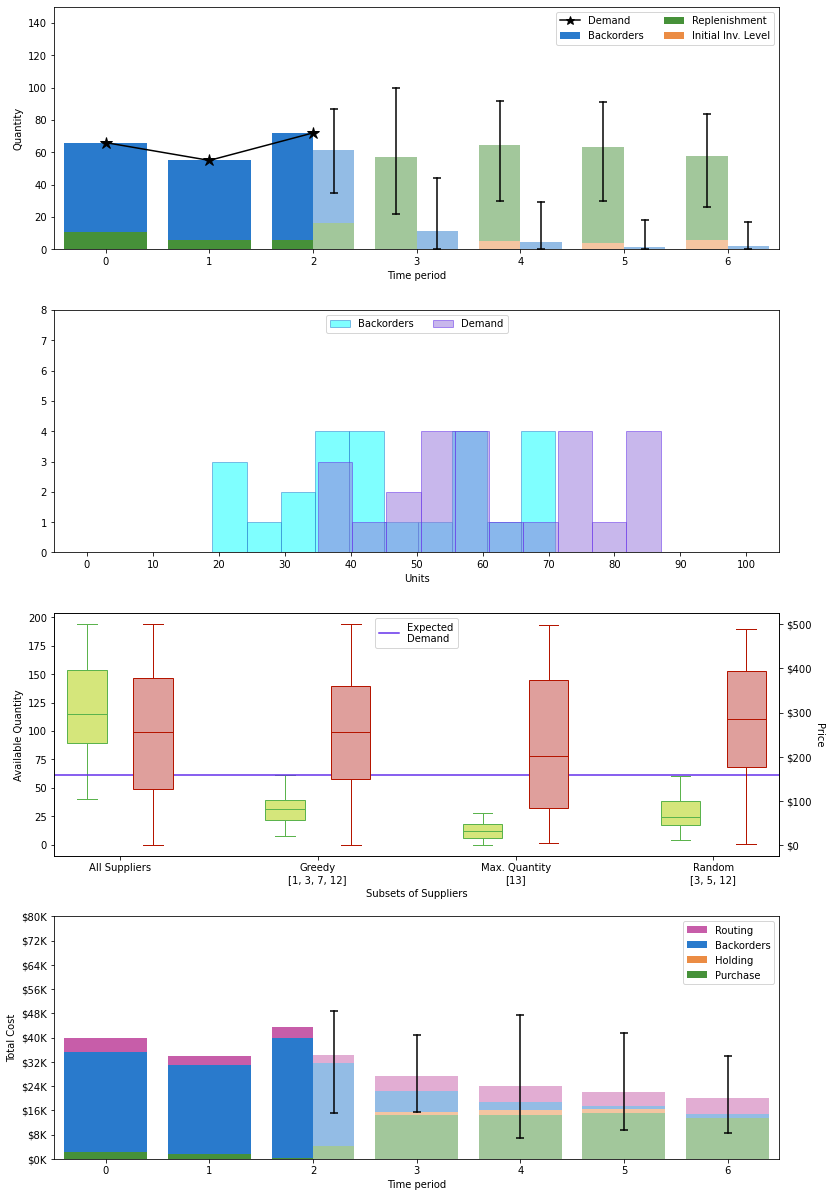

In [13]:

''' Creates historical datasets'''
M_kt, K_it, q, p, d = gen_quantities_prices_demand(Historical, lambda1, K, M, Periods)

''' Creates model fixed parameters'''
h, g, O_k, c, I00 = gen_params(V, T, K, M)

''' Rolling Horizon Implementation'''

big_decisions = ["g" for tau in T]
# Scenario to take it all from
sttiaf = 0

res = Stochastic_Rolling_Horizon(Periods-1,sttiaf,big_decisions,I00)
ii, b, z, x, TW, d_s, p_s, q_s, z_real, ii_real, b_real, I0 = results_translation(res,Periods-1,big_decisions)


'''Visualization'''
azul = (41/255,122/255,204/255)
verde = (70/255,145/255,57/255)
naranja = (235/255,140/255,68/255)
morado = (99/255,45/255,235/255)
rosado = (199/255,93/255,169/255)

decision_colors = {"hold":[naranja,"palegreen"],
                   "back":[azul,"cyan"],
                   "purch":[verde,"palegreen"],
                   "rout":[rosado,"violet"],
                   "dem":[morado,"mediumpurple"],
                   "box_avail":[(91/255,179/255,77/255),(213/255,230/255,123/255)],
                   "box_prices":[(181/255,21/255,0/255),(223/255,159/255,156/255)]}


K = [8,4]
today = 2
save_plots = False


visualization(today,K,sttiaf,big_decisions,"g","r",decision_colors,save_plots)
